In [452]:
import scipy.io.wavfile as wav
import scipy.signal as sig

import matplotlib.pyplot as plt
import numpy as np

import pickle as pk
import math
import IPython.display as ipd
import os

import torch
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm_notebook as tqdm

from itertools import accumulate
from functools import reduce
import operator as op

fs = 48000

## Initial Exploring

Some info about the data: 
- 48 samples per ms, so a window of 256 combines the audio of about 5ms into one stroke of pixels (sliding window half each time, so basically 2.5ms per pixel)
- Taking images of width 128 for example would be 340ms per slice, removing 50ms from that is 15%

Inspecting a random file:

In [322]:
speech = 'corpus/wav48/p225/p225_009.wav'
fs, audio_time = wav.read(speech)

freqs, times, audio_freqs = sig.stft(audio_time, fs)
times, _audio_time = sig.istft(audio_freqs, fs)

In [323]:
data = audio_freqs.view(np.float32).reshape(129, 2, -1).mean(axis=1)
information = [np.abs(d).mean() for d in data]

c:\users\rik\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  """Entry point for launching an IPython kernel.


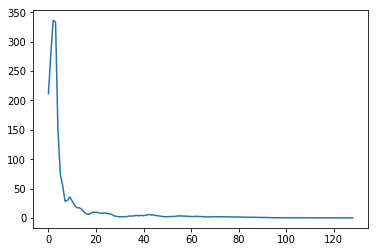

In [324]:
plt.plot(range(129), information)

Trying just the first half of frequencies on bach:

In [325]:
information_acc = np.array(list(accumulate(information)))
information_acc = information_acc / information_acc[-1]

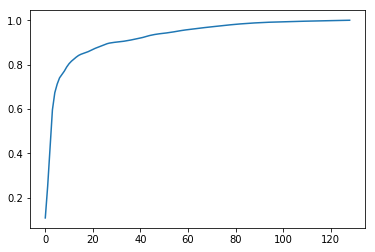

In [326]:
plt.plot(range(129), information_acc)

In [321]:
information_acc[64] # up to 64 contains about 94% off all data (for bach it was 98% even)

0.94380486

So do we really want to take all frequencies, or just everything important, so instead of up till 128, untill 64 for example (this will be 0-12000Hz), apperantly speech data is basically 0-6000Hz (needs a good source), this more than justifyies cutting it off at 12000

(64, 2098)

In [345]:
fs, audio_time = wav.read(speech)
freqs, times, audio_freqs = sig.stft(audio_time, fs)

audio_freqs[64:] = 0

times, _audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(_audio_time, rate=fs) # unsuprizingly you don't hear a difference, original below

In [346]:
ipd.Audio(audio_time, rate=fs)

This is how a missing stroke of 50ms sounds btw:

In [545]:
ms_per_px = (256 / 48) / 2
remove_px = math.floor(50 / ms_per_px)

fs, audio_time = wav.read(speech)
freqs, times, audio_freqs = sig.stft(audio_time, fs)

audio_freqs[:,1500:1500+remove_px] = 0 

times, _audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(_audio_time, rate=fs)

## Dataset Creation

In [477]:
def build_patch_purge_mask(patch_width, patch_height, ms, fs, nperseg=256):
    data_per_ms = (fs / 1000)
    data_per_pixel = (nperseg / 2)
    pixels_per_ms = data_per_ms / data_per_pixel
    pixels = math.floor(ms * pixels_per_ms)
    left_offset = patch_width // 2 - pixels // 2
    
    mask = torch.ones((2, patch_height, patch_width))
    mask[:,:, left_offset:left_offset + pixels] = 0
    
    return mask

def make_whole(freqs, patch_width):
    mod = freqs.shape[2] % patch_width

    if mod is not 0: 
        padding = torch.zeros((freqs.shape[0], freqs.shape[1], patch_width - mod))
        return torch.cat([freqs, padding], dim=2)
    else:
        return freqs
    
def mask_middle(patch_width, patch_height, mask_ms, fs, nperseg=256):
    ms_50_mask = build_patch_purge_mask(patch_width, patch_height, mask_ms, fs, nperseg)
    return lambda x:x * ms_50_mask

def read_monaural_wav(path):
    fs, audio_time = wav.read(path)
        
    if len(audio_time.shape) == 2:
        return fs, audio_time[:,0]
    else:
        return fs, audio_time    
    
def get_all_files(root):
    if os.path.isfile(root):
        return [root]
    else:
        return reduce(op.add, map(lambda c: get_all_files(root + "/" + c), os.listdir(root)), [])
    
def reconstruct_audio(audio_freqs, denorm):
    freqs = denorm(audio_freqs).data.cpu().numpy()
    freqs = freqs[0] + freqs[1] * 1j
    zeros = np.zeros((129, audio_freqs.shape[2]), dtype=np.complex64)
    zeros[:64] = freqs
    
    return sig.istft(zeros, fs)[1]

In [471]:
class FreqDS(Dataset): #TODO add normalization
    def __init__(self, freqs, patch_width: int, idx_mapping=None, transformation=lambda x:x, normalization=lambda x:x):
        self.freqs = freqs
        self.patch_width = patch_width
        self.transformation = transformation
        self.normalization = normalization
        
        if idx_mapping is None:
            idx_mapping = range(freqs.shape[1] // patch_width - 1)
            
        self.idx_mapping = idx_mapping
    
    def __getitem__(self, index):
        index = self.idx_mapping[index]
        rnd = np.random.randint(0, self.patch_width)
        target = self.freqs[:,:,rnd + self.patch_width * index:rnd + self.patch_width * (index + 1)]
        
        target = self.normalization(target) # might as well do this at construction
        X = self.transformation(target)
        
        return X, target
        
    def __len__(self):
        return len(self.idx_mapping)
        
    def save_freq_data(self, path):
        pk.dump((self.freqs, self.patch_width, self.idx_mapping), open(path, "wb")) 
        
    @staticmethod
    def from_file(self, path, transformation):
        return FreqDS(*pk.load(open(path, "rb")), transformation)
    
class AudioDS(FreqDS):    
    def __init__(self, files, transformation, normalization, patch_width: int, max_freqs: int = 64, nperseg: int = 256):
        file_freqs = []
        idx_mapping = []
        
        for i, file in tqdm(enumerate(files), total=len(files)):
            fs, audio_time = read_monaural_wav(file)
            _, _, freqs = sig.stft(audio_time, fs, nperseg=nperseg) 
            
            freqs = torch.from_numpy(freqs.view(np.float32).reshape(129, 2, -1)[:max_freqs].transpose(1, 0, 2))
            freqs = make_whole(freqs, patch_width)
            
            file_freqs.append(freqs)
            
            file_size = freqs.shape[2] // patch_width - 1
            idx_mapping += range(i + len(idx_mapping), i + len(idx_mapping) + file_size)
            
        freqs = torch.cat(file_freqs, dim=2)
        
        super(AudioDS, self).__init__(freqs, patch_width, idx_mapping, transformation, normalization)

In [456]:
STD = 145.8470 # based on just the real

def normalize(p):
    return p / STD
    
def de_normalize(p):
    return p * STD

In [457]:
files = get_all_files("corpus/wav48")
files = list(filter(lambda x: x[-3:] == "wav", files))

transform = mask_middle(128, 64, 50, 48000)

ds_train = AudioDS(files[:1000], transform, normalize, 128, 64)
ds_test = AudioDS(files[1000:1100], transform, normalize, 128, 64)

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=100, shuffle=False)

c:\users\rik\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead


In [523]:
ipd.Audio(reconstruct_audio(ds_train[9][1], de_normalize), rate=fs) # to get the actual audio back from the patch, due to the randomization its a bit different each time

## More Exploration now we have the dataset loaded

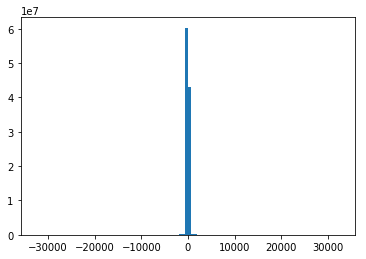

In [349]:
plt.hist(ds_train.freqs[0].view(-1), bins=100)
plt.show()

Definitely needs some normalization, but regardless it will probably really like predicting zero

Simple normalization:

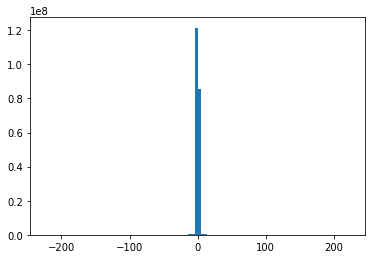

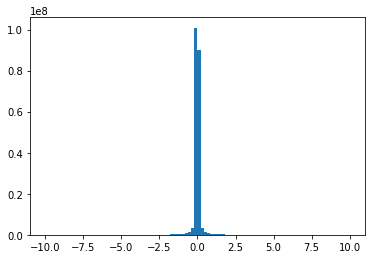

In [384]:
mn = ds_train.freqs.mean()
sd = ds_train.freqs.std()

data = (ds_train.freqs - mn) / sd
points = data.view(-1)

plt.hist(points, bins=100)
plt.show() 

plt.hist(points, bins=100, range=(-10,10))
plt.show() 

Great progres...

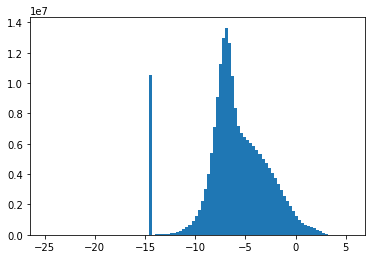

In [424]:
data = (ds_train.freqs - mn) / sd
points = data.view(-1)

plt.hist(np.log(np.abs(points)), bins=100)
plt.show() 

So quite a lot <1, and quite a bit exactly at 0

This is how it sounds if you cut away everything between [-1,1] (so putting everything in the above plot that is to the left of zero in the peak at -15, so most of it):

In [425]:
fs, audio_time = wav.read(speech)

_, _, audio_freqs = sig.stft(audio_time, fs)
audio_freqs = audio_freqs.view(np.float32).reshape(129, 2, -1).transpose(1, 0, 2)
freqs = audio_freqs[0]
freqs = (freqs - mn.item()) / sd.item()
freqs[abs(freqs) < 1] = 0
freqs = freqs * sd.item() + mn.item()
audio_freqs = freqs + audio_freqs[1] * 1j

_, audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(audio_time, rate=fs)

c:\users\rik\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  after removing the cwd from sys.path.


No real difference, plot becomes

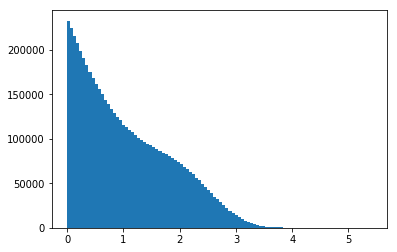

In [426]:
data = (ds_train.freqs - mn) / sd
points = data.view(-1)

plt.hist(np.log(np.abs(points[np.abs(points) > 1])), bins=100)
plt.show() 

which looks a lot easier for the AI to do predictions on :), although we did loose the sign which is definitely not OK. So options are a different normalization, or giving sign information to the NN sepperately

Another option for normalziation is to normalize each frequency seperatly, but this would destroy the meaning of the actual numbers when compared across frequencies, which might make fixing it more difficult.

So bottom line, look how other papers do it.

## Training Stuff

In [444]:
from rml import training
from rml import utils

In [445]:
utils.utils.set_is_notebook(True)

In [446]:
import torch.nn.functional as F

from unet.unet.unet_parts import *

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = inconv(2, 64) # the complex and real are just used as two channels of an image, there might be a much better way to go about that though, perhaps reconstructing them sepperatly might not be such a bad idea (will also show which one of the two is more difficult)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, 2)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

just very simple MSELoss for now, need to think about what kind of feature/pixel loss would it help learning best, since with only simple normalization, this will most likely learn to set everything to about zero also when normalizing with log e.g. do we take MSE with respect to that, or first take the exponent of it (in which case the loss will be much higher if slight mistakes are made, so it is very much insentiviced to get it just right), getting it about right would be good enough if now, etc... just stuff to think about; probably again, some good suggestions in other papers

In [442]:
model = UNet()
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.MSELoss()

In [ ]:
training.optimize(1, model, optim, loss, dl_train, dl_test) 